# <span style="color:navy;"> Lecture 8: Model Optimization and Cross Validation </span>

## Risky Business

Thus far in the course, you have learned that machine learning tasks, particularly Supervised Learning methods, involve minimizing some sort of loss function, e.g. Means Squared Error for Ordinary Least Squares Regression.

In this document, we will approach this concept with more depth, introducing the topic of risk functions, while exploring the implications of one of the more significant topics in understanding risk, the Bias-Variance Tradeoff, Model Optimization, and Cross Validation.

Make sure to run this block before running any other code blocks.

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import *
from sklearn import svm

## Risk and Loss Functions

While it would be wonderful if a single notion success and failure was inherent to the study of data science, this is not the case. Therefore, we must be resigned to either defining or choosing our own metric for success, in order to reason about our model and data.

To do this, we define a **Loss Function**, a function $L(\hat{y},y)$ which takes a predicted value and the corresponding true value and maps them to a value in the Real Numbers. This function serves as our metric for the loss caused by a particular prediction in our model (because of reasons we won't get into, minimizing loss is generally superior to attempting to maximize success); by outputting numbers in the Reals, we are better able to quantify and compare the loss in our models.

While knowing what we've lost while training the model is vital moving forward, we must remember that our real objective is minimizing the amount of loss we'll see in the future. For this, we introduce something called a **Risk Function**, also known as Expected Loss, which is a function $R(\hat{Y},Y)$ that takes two Random Variables and maps them to the Real numbers. This serves as a measure for how much loss you expect to see for future predictions - our objective then becomes minimizing this function, thus (ideally) making our future predictions more accurate.

It should be known that your choice of loss function has a drastic effect on your model - indeed, new models are often defined with only small changes to an existing loss function (see Ridge Regression later in these notes). Then we must be aware of the implications and behavior of any formulation of a loss function we choose. One of, if not the most common loss functions is $L_2$ loss: $$L_2(\hat{Y}, Y) = (\hat{Y} - Y)^2$$

Indeed, it's Squared Error, which many of you may recognize from Mean Squared Error, which was in fact a risk function.

## Bias-Variance Decomposition

Now, loss and risk functions are just like any other mathematical function - as such we have a fair amount of freedom to play around with them. Consider the following example, starting with Expected $L_2$ loss:

\begin{align*}
    R(\hat{Y}, Y) = E[L_2(\hat{Y}, Y)] &= E[(\hat{Y} - Y)^2] \\
    &= (Y - E[\hat{Y}])^2 + E[(\hat{Y} - E[\hat{Y}])^2] + Var[Y] \\
    &= Bias^2[\hat{Y}] + Var[\hat{Y}] + \sigma^2
\end{align*}

Now, this may seem fairly mundane (though rather arcane: a full proof is provided here for the curious), but the concepts behind it are vital to reasoning about what we do as data scientists. To better understand this, let's break down the components of the Bias-Variance Decomposition.

### Starting off on the wrong foot - Bias

The first component to look at is something called Bias - essentially, Bias is a measure of the effect of our initial reasoning about our model. It is a consistent error throughout the system, resulting from poor or limiting assumptions, insufficient training or oversymplification of the model.

A model with high bias will not change too much between different uses - unless of course, we change our assumptions. Linear models are examples of models with high bias.

![Lazy Bias](./lazybias.png)

Notice that the linear model in the above image does not conform to the data, despite there being a clear trend along the curve. Our assumptions of linearity are very strong, and it reflects in the model, giving it high bias.

### In Need of Consistency - Variance

Variance is a more common statistical topic than Bias and is one that you may have come across in past classes. Put simply, Variance is a measure of how much some thing changes; in this context, it's how much a model may vary depending on the training data used.

A model with high Variane may change wildly between uses, unless some sort of constraint is imposed upon it. As a result, it is particularly sensitive to noise. As such, Variance is also known as random error in this context. An example of a model with (comically) high variance is 1-Nearest-Neighbors.

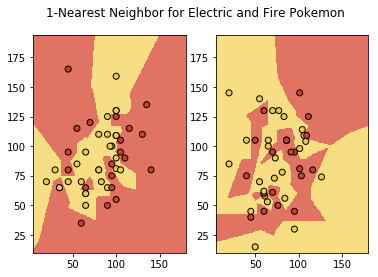

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors as ne
import pandas as pd
from matplotlib.colors import ListedColormap

poke = pd.read_csv("./Pokemon.csv")
poke['TN'] = poke['Type 1'].astype('category').cat.codes
type_mask = poke['Type 1'].isin(['Fire','Electric'])
type_num = {'Fire':0, 'Electric':1}
EorF = poke[type_mask]

cml = ListedColormap(['#E17362', '#F7DE82'])
cmb = ListedColormap(['#cf3e28', '#f2cb3a'])

stp = 0.5

s1 = EorF.iloc[:(EorF.shape[0] // 2), :]
s2 = EorF.iloc[(EorF.shape[0] // 2):, :]

xcol = ['Speed', 'Sp. Atk']
ycol = 'TN'

spmin, spmax = 5, 180
samin, samax = 10, 194

plt.figure(1)
plt.subplot(121)

nn = ne.KNeighborsClassifier(n_neighbors=1)
nn.fit(s1[xcol].as_matrix(), s1[ycol].as_matrix())
    

xx, yy = np.meshgrid(np.arange(spmin, spmax, stp),
                      np.arange(samin, samax, stp))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cml)

plt.scatter(s1['Speed'].as_matrix(), s1['Sp. Atk'].as_matrix(), c=s1[ycol], cmap=cmb, edgecolor='black')

plt.subplot(122)

nn = ne.KNeighborsClassifier(n_neighbors=1)
nn.fit(s2[xcol].as_matrix(), s2[ycol].as_matrix())

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cml)

plt.scatter(s2['Speed'].as_matrix(), s2['Sp. Atk'].as_matrix(), c=s2[ycol], cmap=cmb, edgecolor='black')

plt.suptitle("1-Nearest Neighbor for Electric and Fire Pokemon")
plt.show()

As you can see, the two models apear to be quite different, even though they were run on two sets with fairly similar data.

### Along for the Ride - Irreducible Error

Irreducible Error, written here as \sigma, is error that is inherent to the data. Much as we would like to believe that we could reduce our expected error to zero, the irreducible error constant prevents this. While irreducible error is always present, there's not much that we can really do about it, so don't pay it too much heed.

### Lets Revisit the Equation - the Bias-Variance Tradeoff

Consider again our alternate equation for expected loss: $$E[L_2(\hat{Y}, Y)] = Bias^2[\hat{Y}] + Var[\hat{Y}] + \sigma^2$$

Notice that this implies that expected error conserves - this makes logical sense, as reducing bias (and loosening constraints on the system), comes with the penalty of increased variance, as the model will be more free to move and change, and vice versa.

This is what we call the Bias-Variance tradeoff, and it should be easily understood: a model must neither be too complex and be allowed to change freely, nor must it be too simple and conform too closely to a particular assumption.

### Highs and Lows - X-Fitting

As it  turns out, we have names for the inbalance of bias and variance depending on which is too high or too low. 

They are as follows:

* Underfitting : Underfitting is the situation where the model has High Bias and Low Variance 
* Overfitting : Overfitting is the situation where the model has High Variance and Low Bias

In either one of these cases, the model will be unabl to capture the overall trend in the data - let us know consider two examples to determine why this is the case.

<img src="./Under.png" style="width: 400px;"/>

This image shoes an example of underfitting - it is unable to capture the trend because it is unable to conform more to the data - the trend is beyond the assumptions used in the model.

<img src="./Overfit.png" style="width: 400px;"/>

This image shoes an example of overfitting - once again, it is unable to reasonably capture the trend in the data. This time, however, it is because the model is unable to discern noise from the more valuable data.

<img src='http://docs.aws.amazon.com/machine-learning/latest/dg/images/mlconcepts_image5.png' alt='From Amazon Web Services'>

## Approaching Over/Underfitting

While Under and Overfitting may reduce the accuracy of our models, or even render them useless, we do not have to be content with it. Here, we'll introduce (and briefly reintroduce) two methods for reducing \<X\>-fitting problems.

### Hyperparameters

Hyperparameters should be nothing new to the reader; they are a parameters chosen by the user in order to affect the behavior of the model. They also happen to be the one of the more effective ways of adjusting a model so to stop it from over/underfitting.

Take KNN for example: choosing low values of K will tend to produce models with very high variance and low bias, whereas higher values of K will tend to procude models with High Bias and low variance.

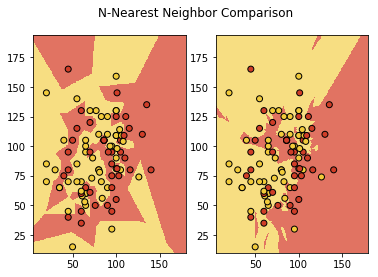

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors as ne
import pandas as pd
from matplotlib.colors import ListedColormap

poke = pd.read_csv("./Pokemon.csv")
poke['TN'] = poke['Type 1'].astype('category').cat.codes
type_mask = poke['Type 1'].isin(['Fire','Electric'])
type_num = {'Fire':0, 'Electric':1}
EorF = poke[type_mask]

cml = ListedColormap(['#E17362', '#F7DE82'])
cmb = ListedColormap(['#cf3e28', '#f2cb3a'])

stp = 0.5

xcol = ['Speed', 'Sp. Atk']
ycol = 'TN'

spmin, spmax = 5, 180
samin, samax = 10, 194

plt.figure(1)
plt.subplot(121)

nn = ne.KNeighborsClassifier(n_neighbors=1)
nn.fit(EorF[xcol].as_matrix(), EorF[ycol].as_matrix())
    

xx, yy = np.meshgrid(np.arange(spmin, spmax, stp),
                      np.arange(samin, samax, stp))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cml)

plt.scatter(EorF['Speed'].as_matrix(), EorF['Sp. Atk'].as_matrix(), c=EorF[ycol], cmap=cmb, edgecolor='black')

plt.subplot(122)

nn = ne.KNeighborsClassifier(n_neighbors=16)
nn.fit(EorF[xcol].as_matrix(), EorF[ycol].as_matrix())

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cml)

plt.scatter(EorF['Speed'].as_matrix(), EorF['Sp. Atk'].as_matrix(), c=EorF[ycol], cmap=cmb, edgecolor='black')

plt.suptitle("N-Nearest Neighbor Comparison")
plt.show()

### Regularization

Regularization is a method for rexducing overfitting by reducing the complexity of the model, or to add constraints to the model in order to achieve a more unique solution.

You see, model complexity should be treated as a resource; the reason for this, is that while training error does decrease by adding additional variables or by heavily weighting two colinear examples, this will do nothing for, or perhaps even harm, your testing error. The reason being is that an overly complex model becomes exceptionally hard to generalize as it grows.

Take *Ridge Regression* for example: Ridge Regression is an expansion of Ordinary Least Squares Regression which adds a regularization term to it's loss function: $$L(\hat{Y}, Y) = (\hat{Y} - Y)^2 + \alpha\|\beta\|^2$$
That final term $\|\beta\|^2$ penalizes the size and number of coefficients in the linear model. The severity of this penalty is set using the $\alpha$ coefficient preceding the term. 

Thus, the values of the coefficients of the model will be kept small unless they have a substantial effect on the accuracy of the model. Look at this graph from the scikit-learn notes:

![Ridge Coefficients](./sphx_glr_plot_ridge_path_0011.png)

As you can see, regularization has a significant impact on the complexity of the model. Picking good values for $\alpha$ is vital to proper function, however.

Ridge regression is useful for predictor variables that are correlated and not sparse, and when the predictors have small individual effects.

<h1> Validation and Cross Validation </h1>

Since training and testing error are so different, it's imperative to always have a testing set to verify how the model will perform "in the wild." However, we usually want to keep any test set we define untouched until our model has been fully constructed and trained. Therefore, We have to be parsimonious with our training data and use cross validation to approximate our testing error using our training set. Essentially, some subset of the training set is kept as a validation set that is used to approximate the model's test error during training.

The simplest type of cross validation is the validation set method. This is when part of the training set is allocated as the "validation set", or a pseudo-training set. The model is trained on the non-validation portion and is tested on the validation portion. We can then tune model parameters to reduce under/overfitting as we need, and repeat the process until we are satisfied with the training error and validation error we get. 

Without validation, you lose the ability to approximate how good your model is without having test data. Imagine having a machine learning model for some application used in the real world: you need to know how the model performs before your application is deployed. Validation is a way of assessing how your model will do when it is given new data which isn't really "new" data. 

<img src='https://www.intechopen.com/source/html/39037/media/image3.jpeg' alt= 'From InTech'>

<h2>Implementing Cross-validation </h2>

It's important to be careful with terminology. When we say "validation error", this refers to the error computed by the model upon with some validation set, which is a subset of the training set. Since the model isn't trained on that subset of the training data, this is an effective way to approximate what test error will be. 

* <i>k</i>-fold
    - Create <i>k</i> partitions (folds) of the data. For each fold, treat the other <i>k−1</i> folds as the training data and the remaining fold as the testing data. Compute the test error.  The overall cross validated error is the average of all of these error values.


* LOOCV
    - LOOCV stands for Leave Out One Cross Validation, where one training sample is used as validation while the rest is kept as training data. This is the same as <i>k</i>-fold cross-validation where <i>k</i> is equal to the size of the training set <i>n</i>.
    - More generally, we can leave-<i>p</i>-out. For each data point, leave out p points and train the model on the rest of the points, and compute test error.  The overall cross validated error is the average of all of these error values.
   
Let's run through the code for these using an example from <a href='http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html'>sklearn documentation</a>: 

In [4]:
# Modifications to the original code have been added
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import sklearn.model_selection

#Load dataset and split into training and test samples
iris = datasets.load_iris()
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,test_size=0.15,random_state=0)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(127, 4)
(127,)
(23, 4)
(23,)


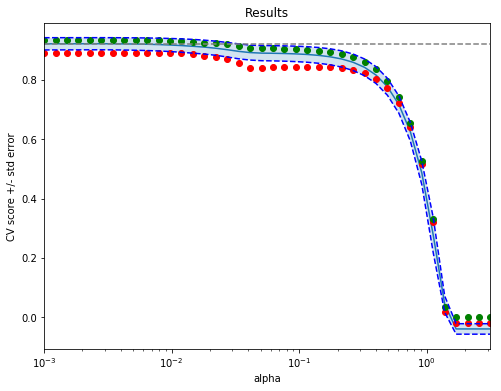

In [5]:
#Create a lasso model
lasso = Lasso(random_state=0)
alphas = np.logspace(-3, 0.5, 40) #Create a np array of alpha, a parameter of the lasso model


scores = list()
scores_std = list()
actual_scores = list()
train_scores= list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X_train, y_train, cv=n_folds) #calculate validation accuracy with this alpha
    scores.append(np.mean(this_scores))
    
    lasso.fit(X_train,y_train)
    
    train_score = lasso.score(X_train,y_train)
    train_scores.append(train_score)
    
    actual_test_score = lasso.score(X_test,y_test)
    actual_scores.append(actual_test_score)

    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

#Plot results
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)
plt.title('Results')

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, np.array(actual_scores),'ro') #Red dotted line shows actual test score as alpha changes
plt.semilogx(alphas, np.array(train_scores),'go') #Green dotted line shows training accuracy as alpha changes

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()